# 使用手寫辨識資料集, 觀察 PCA 算法

# [作業目標]
- 試著模仿範例寫法, 以變更參數後的 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

# [作業重點]
- 以手寫辨識資料集, 觀察變更參數後的 PCA 算法, 在取不同 component 時, PCA 解釋度與分類正確率如何變化 (In[5], Out[5])

In [3]:
# 載入套件
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 定義 PCA 與隨後的羅吉斯迴歸函數
# penalty 改為 L1, max_iter 改為 100
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# 載入手寫數字辨識集
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [15]:
# 先執行 GridSearchCV 跑出最佳參數
# pipeline怎麼用？ 要找出哪些最佳參數？
#
# sklearn.linear_model.SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, ....
# 
# sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False,
#     svd_solver=’auto’, tol=0.0, iterated_power=’auto’, random_state=None)
#
# sklearn.model_selection.GridSearchCV(estimator, param_grid
#    estimator: 可以給一個pipeline
#    param_grid: 可以給一個dict,key是pipeline裡的step name + "__"(兩個underscore) + 所屬estimater裡的參數名
from sklearn.model_selection import GridSearchCV

param_grid = {'pca__n_components' : [4, 10, 20, 30, 40, 50, 64], 'logistic__alpha' : [0.1, 0.01, 0.001, 0.0001]}
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid)
grid_search.fit(X_digits, y_digits)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l...y='l1', power_t=0.5, random_state=0, shuffle=True,
       tol=1e-05, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'pca__n_components': [4, 10, 20, 30, 40, 50, 64], 'logistic__alpha': [0.1, 0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

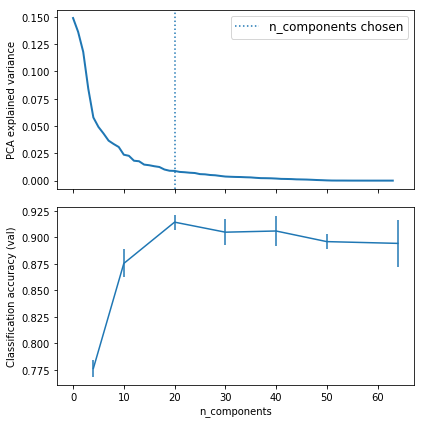

In [16]:
# 繪製不同 components 的 PCA 解釋度
# 所謂「解釋度」，其實就是PCA裡的一個屬性：explained_variance_ratio_
# pca要先fit過，才有這個屬性值
pca.fit(X_digits)

# 把「解釋度」和「正確率」用sharex=True的方式，畫在同一張圖上以共用X軸（pca's n_components）
# matplotlib.pyplot.subplots(nrows=1, ncols=1, sharex=False, sharey=False, 
#    squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)[source]

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

# axvline: Add a vertical line across the axes , 用找到的最佳n_components值畫一條垂直線
# 注意這裡從best_estimator取值的寫法
ax0.axvline(grid_search.best_estimator_.named_steps['pca'].n_components, linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# 繪製不同採樣點的分類正確率
results = pd.DataFrame(grid_search.cv_results_)
components_col = 'param_pca__n_components'
# DataFrame.nlargest(n, columns, 取出mean_test_score這一欄的最大值
best_clfs = results.groupby(components_col).apply(lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout()
plt.show()

### Answer:

- 結果和範例程式稍有不同，n_components在20以後，呈現緩步下滑，20顯然是較佳的值
